In [ ]:
!pip install torch
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



### Reference 

- Digital Signal Processing Lecture
https://github.com/spatialaudio/digital-signal-processing-lecture 

- Python for Signal Processing (unipingco)
https://github.com/unpingco/Python-for-Signal-Processing 

- Audio for Deep Learning (남기현님)
https://tykimos.github.io/2019/07/04/ISS_2nd_Deep_Learning_Conference_All_Together/ 

- 오디오 전처리 작업을 위한 연습 (박수철님)
https://github.com/scpark20/audio-preprocessing-practice 

- Musical Applications of Machine Learning
https://mac.kaist.ac.kr/~juhan/gct634/ 

- Awesome audio study materials for Korean (최근우님)
https://github.com/keunwoochoi/awesome-audio-study-materials-for-korean

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True) 
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
test_dataset[1]
#소리 데이터, 샘플레이트 

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [ ]:
from IPython.display import Audio
Audio(test_dataset[1][0].numpy()[0], rate=16000)

In [ ]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

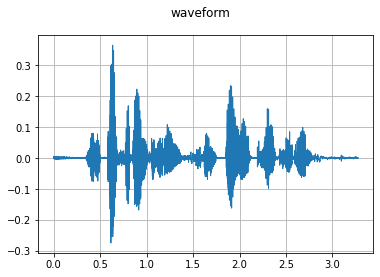

In [ ]:
plot_waveform(test_dataset[1][0], sample_rate=16000)

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

def _levenshtein_distance(ref, hyp):
    """"Levenshtein distance"는 두 시퀀스 간의 차이를 측정하기위한 문자열 메트릭입니다. 
    "Levenshtein distance"는 한 단어를 다른 단어로 변경하는 데 필요한 최소 한 문자 편집 (대체, 삽입 또는 삭제) 수로 정의됩니다. 
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


In [ ]:
def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """참조 시퀀스와 가설 시퀀스 사이의 거리를 단어 수준으로 계산합니다.
     : param reference : 참조 문장.
     : param hypothesis : 가설 문장.
     : param ignore_case : 대소 문자 구분 여부.
     : param delimiter : 입력 문장의 구분자.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)

In [ ]:
def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

In [ ]:
def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). 
    WER = (Sw + Dw + Iw) / Nw
    Sw는 대체 된 단어의 수입니다.
    Dw는 삭제 된 단어의 수입니다.
    Iw는 삽입 된 단어의 수입니다.
    Nw는 참조의 단어 수입니다.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer

In [ ]:
def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). 
        CER = (Sc + Dc + Ic) / Nc
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

네트워크의 출력은 각 언어의 문자소입니다. 각 출력 시간 단계 t에서 RNN은 문자 p(`t|x)에 대한 예측을 수행합니다. 여기서 `t는 알파벳의 문자이거나 빈 기호입니다.
영어에서는 `t ∈ {a, b, c, . . . , z,공백, 아포스트로피, 공백},

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


두 경우 모두 빔 검색 디코딩 단계에서 언어 모델을 통합합니다.

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

ReLU(clipped rectifiedlinear) 함수 σ(x) = min{max{x, 0}, 20}을 비선형성으로 사용합니다.

우리가 실험하는 아키텍처는 하나 이상의 컨볼루션 레이어, 하나 이상의 순환 레이어, 하나 이상의 완전 연결 레이어로 구성됩니다.
계층 l의 숨겨진 표현은 h 0이 입력 x를 나타내는 규칙과 함께 h l에 의해 제공됩니다.
네트워크의 바닥은 입력 p의 시간 차원에 대한 하나 이상의 컨볼루션입니다.

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

# The two sets of activations are summed to form the output activations for the layer h The function g(·) can be the standard recurrent operation
class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

class SpeechRecognitionModel(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
  
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

def load_dataset(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, _, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        
    return spectrograms

def get_dataloader(data):
    x_train = load_dataset(data, "train")
    x_valid = load_dataset(data, 'valid')

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std

    train_set = Dataset(x_train)
    vaild_set = Dataset(x_valid)

    train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=4, shuffle=False, drop_last=False)
    
    return train_loader, valid_loader

이 튜토리얼에서는 "greedy"디코딩 방법을 사용하여 모델의 출력을 문자로 결합하여 대화 내용을 만들 수 있습니다. "greedy"디코더는 모델의 소프트 맥스 확률 문자 인 모델 출력을 취하며 각 시간 단계에 대해 가장 높은 확률을 가진 레이블을 선택합니다. 라벨이 빈 라벨 인 경우 최종 성적표에서 라벨이 제거됩니다.

In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            # The output layer L is a softmax computing a probability distribution over characters given
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate=5e-4, batch_size=20, epochs=10,
        train_url="train-clean-100", test_url="test-clean"):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }


    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    # train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    # test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.Adam(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)

    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, epoch, iter_meter)
        test(model, device, test_loader, criterion, epoch, iter_meter)

    torch.save(model, 'model.pth')


In [ ]:
learning_rate = 5e-4
batch_size = 10
epochs = 3
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

Num Model Parameters 23705373
Train Epoch: 1 [0/28539 (0%)]	Loss: 6.524860
Train Epoch: 1 [1000/28539 (4%)]	Loss: 2.887663
Train Epoch: 1 [2000/28539 (7%)]	Loss: 2.882060
Train Epoch: 1 [3000/28539 (11%)]	Loss: 2.848446
Train Epoch: 1 [4000/28539 (14%)]	Loss: 2.873396
Train Epoch: 1 [5000/28539 (18%)]	Loss: 2.892202
Train Epoch: 1 [6000/28539 (21%)]	Loss: 2.862144
Train Epoch: 1 [7000/28539 (25%)]	Loss: 2.845948
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.954591
Train Epoch: 1 [9000/28539 (32%)]	Loss: 2.879437
Train Epoch: 1 [10000/28539 (35%)]	Loss: 2.897772
Train Epoch: 1 [11000/28539 (39%)]	Loss: 2.902271
Train Epoch: 1 [12000/28539 (42%)]	Loss: 2.873627
Train Epoch: 1 [13000/28539 (46%)]	Loss: 2.838299
Train Epoch: 1 [14000/28539 (49%)]	Loss: 2.847373
Train Epoch: 1 [15000/28539 (53%)]	Loss: 2.847005
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.833949
Train Epoch: 1 [17000/28539 (60%)]	Loss: 2.874572
Train Epoch: 1 [18000/28539 (63%)]	Loss: 2.865529
Train Epoch: 1 [19000/28539 (67%)]	L

In [55]:
def pred_test(model, device, test_loader):
    print('\nevaluating...')
    model.eval()
    test_cer, test_wer = [], []
    with torch.no_grad():
        _data = next(iter(test_loader))
        print(_data)
                
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)
        # The output layer L is a softmax computing a probability distribution over characters given
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

        print('decoded_preds' , decoded_preds)
        print('decoded_targets' , decoded_targets)
        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    print('Predict set: Average CER: {:4f} Average WER: {:.4f}\n'.format( avg_cer, avg_wer))

In [56]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
pred_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

model = torch.load("model.pth")
device = torch.device("cuda" if use_cuda else "cpu")
pred_test(model, device, pred_loader)


evaluating...
[tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.8849e-03, 8.9356e-04, 1.0820e-03,  ..., 1.0969e-03,
           2.5526e-03, 1.8694e-03],
          [1.0149e-02, 4.8112e-03, 5.8257e-03,  ..., 5.9059e-03,
           1.3744e-02, 1.0065e-02],
          ...,
          [1.1434e-06, 1.1607e-05, 6.3036e-06,  ..., 6.5789e-06,
           4.0343e-06, 5.7677e-06],
          [1.3177e-06, 1.2293e-05, 5.0797e-06,  ..., 5.1214e-06,
           5.9359e-06, 5.5154e-06],
          [2.9302e-06, 7.4516e-06, 4.6394e-06,  ..., 6.7297e-06,
           1.9236e-05, 1.0241e-05]]]]), tensor([[ 9.,  6.,  1.,  9., 16., 17.,  6.,  5.,  1., 21.,  9.,  6., 19.,  6.,
          1., 24., 16., 22., 13.,  5.,  1.,  3.,  6.,  1., 20., 21.,  6., 24.,
          1.,  7., 16., 19.,  1.,  5., 10., 15., 15.,  6., 19.,  1., 21., 22.,
         19., 15., 10., 17., 20.,  1.,  2., 15.,  5.,  1.,  4.,  2., 19., 19.,
         16., 21., 20.,  1.,  2., 15.,  5.,

In [57]:
from IPython.display import Audio
Audio(test_dataset[0][0].numpy()[0], rate=16000)